In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import dsa
from dsa import *
from models import mlp
import pickle
from sklearn.model_selection import train_test_split

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

aux_target_ratio = 0.2

xy = np.loadtxt("../datasets/drive-diagnosis.txt")
np.random.shuffle(xy)
x = xy[:,0:-1]
y = xy[:,-1]

x = (x - np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
y = y.reshape((len(x), 1)).astype("float32")-1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=aux_target_ratio/(aux_target_ratio+1), random_state=42)

target_ds = make_dataset(x_train, y_train, lambda t: t)
aux_ds = make_dataset(x_test, y_test, lambda t: t)

2022-04-05 02:49:19.272144: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-05 02:49:19.272193: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xgpd6
2022-04-05 02:49:19.272202: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xgpd6
2022-04-05 02:49:19.272342: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-04-05 02:49:19.272374: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-04-05 02:49:19.272381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-04-05 02:49:19.272832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in per

In [6]:
drive_dsa = {}
log_drive_dsa = {}

for split in [4,3,2]:
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=48, class_num=11, split=split, units=256, ed_act="relu")
    drive_dsa[split] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log_drive_dsa[split] = drive_dsa[split].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        acc_fn=tf.keras.metrics.SparseCategoricalAccuracy(),
        batch_size=32,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.00001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.00001,
        lr_c=0.0001,
        log_freq=500)

======Split level is 4======
Iteration 500, train accuracy: 0.4506108463704586, average attack MSE: 0.09695069408416748
Iteration 1000, train accuracy: 0.6566906830072403, average attack MSE: 0.07178463346511126
Iteration 1500, train accuracy: 0.7192247763872147, average attack MSE: 0.0791542524844408
Iteration 2000, train accuracy: 0.7485957812070847, average attack MSE: 0.06997532237321138
Iteration 2500, train accuracy: 0.7672932176589966, average attack MSE: 0.0737865640372038
Iteration 3000, train accuracy: 0.7826867372989654, average attack MSE: 0.0797378967255354
Iteration 3500, train accuracy: 0.792970779299736, average attack MSE: 0.07513301491737366
Iteration 4000, train accuracy: 0.8019453023672104, average attack MSE: 0.07102456844598055
Iteration 4500, train accuracy: 0.8101702963113785, average attack MSE: 0.08165554661303759
Iteration 5000, train accuracy: 0.8173243073225022, average attack MSE: 0.0800749971717596
Iteration 5500, train accuracy: 0.8242008700370789, avera

In [7]:
from fsha import *

drive_fsha={}
log_drive_fsha={}

for split in [4,3,2]:
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    hparams = {
        'WGAN' : False,
        'style_loss' : None,
        'lr_f' :  0.001,
        'lr_tilde': 0.001,
        'lr_D': 0.001,
        'lr_g': 0.001
    }
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp_fsha(attr_num=48, class_num=11, split=split, units=256, ed_act=None)
    models = (make_f, make_g, make_e, make_d, make_c)
    drive_fsha[split] = FSHA(
        target_ds, aux_ds,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        acc_fn=tf.keras.metrics.SparseCategoricalAccuracy(), models=models, batch_size=32, hparams=hparams)
    log_drive_fsha[split]=drive_fsha[split](10000, verbose=True, progress_bar=False, log_frequency=1000)

======Split level is 4======
RUNNING...
Iteration 0000000 train accuracy: 0.0938, validation: 0.0971
Iteration 0001000 train accuracy: 0.0893, validation: 0.0629
Iteration 0002000 train accuracy: 0.0907, validation: 0.0528
Iteration 0003000 train accuracy: 0.0905, validation: 0.0643
Iteration 0004000 train accuracy: 0.0915, validation: 0.0328
Iteration 0005000 train accuracy: 0.0923, validation: 0.0355
Iteration 0006000 train accuracy: 0.0917, validation: 0.0174
Iteration 0007000 train accuracy: 0.0913, validation: 0.0116
Iteration 0008000 train accuracy: 0.0912, validation: 0.0116
Iteration 0009000 train accuracy: 0.0910, validation: 0.0116
======Split level is 3======
RUNNING...
Iteration 0000000 train accuracy: 0.0312, validation: 0.0971
Iteration 0001000 train accuracy: 0.0934, validation: 0.0429
Iteration 0002000 train accuracy: 0.0921, validation: 0.0221
Iteration 0003000 train accuracy: 0.1038, validation: 0.0245
Iteration 0004000 train accuracy: 0.1047, validation: 0.0195
Itera

In [8]:
with open('log/drive-dsa.pkl', 'wb') as f:
    pickle.dump(log_drive_dsa, f)
with open('log/drive-fsha.pkl', 'wb') as f:
    pickle.dump(log_drive_fsha, f)

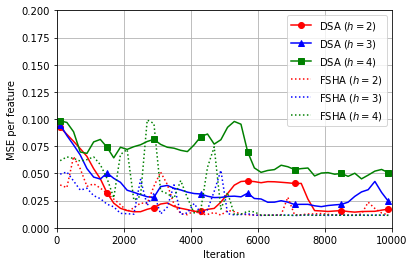

In [11]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.ylim([0,0.2])
plt.xlim([0,10000])
plt.grid()

sampled_loss = {}
sampled_fsha_loss = {}

for split in [2,3,4]:
    sampled_loss[split] = [sum(log_drive_dsa[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_drive_dsa[split][:,0])/log_freq))]
    sampled_fsha_loss[split] = [sum(log_drive_fsha[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_drive_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.ylabel('MSE per feature')
plt.xlabel('Iteration')
plt.plot(ran, sampled_loss[2], 'ro-', ran, sampled_loss[3], 'b^-', ran, sampled_loss[4], 'gs-', markevery=7)
plt.plot(ran, sampled_fsha_loss[2], 'r:', ran, sampled_fsha_loss[3], 'b:', ran, sampled_fsha_loss[4], 'g:')
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/drive.pdf", bbox_inches='tight')

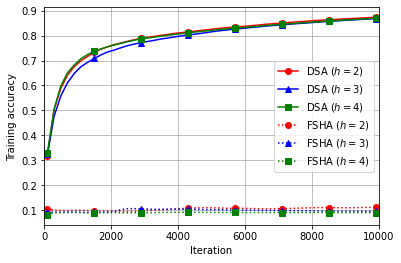

In [13]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,10000])
plt.grid()

sampled_acc = {}
sampled_fsha_acc = {}

for split in [2,3,4]:
    sampled_acc[split] = [sum(log_drive_dsa[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_drive_dsa[split][:,0])/log_freq))]
    sampled_fsha_acc[split] = [sum(log_drive_fsha[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_drive_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.ylabel('Training accuracy')
plt.xlabel('Iteration')
plt.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.plot(ran, sampled_fsha_acc[2], 'ro:', ran, sampled_fsha_acc[3], 'b^:', ran, sampled_fsha_acc[4], 'gs:', markevery=7)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.ylabel('Training accuracy')
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/drive-acc.pdf", bbox_inches='tight')